Project 4 - Advanced Lane Finding - Report. Vilas Chitrakaran. Feb 2017

## Executive Summary

__TODO__

## Camera Calibration

Corner detection failed on  ./camera_cal/calibration1.jpg
Corner detection failed on  ./camera_cal/calibration5.jpg
Corner detection failed on  ./camera_cal/calibration4.jpg
Camera intrinsic matrix:
 [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion parameters:
 [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]
Test undistortion on one of the images


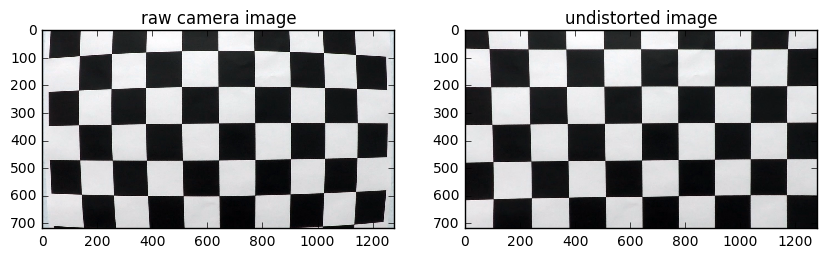

In [40]:
#=====================================================================
# Camera calibration
# Note: The following comes from code provided in examples directory

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt5
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), cv2.CALIB_CB_ADAPTIVE_THRESH)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.figure()
        cv2.imshow('img',img)
        cv2.waitKey(500)
    else:
        print("Corner detection failed on ", fname)

cv2.destroyAllWindows()

# now calibrate the camera
ret, cam_mtx, dist_pars, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera intrinsic matrix:\n', cam_mtx)
print('Camera distortion parameters:\n', dist_pars)

# test undistortion
img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, cam_mtx, dist_pars, None, cam_mtx)

print('Test undistortion on one of the images')
f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(img)
axarr[0].set_title('raw camera image')
axarr[1].imshow(undist)
axarr[1].set_title('undistorted image');


## Setup Perspective Transform

* Find an image with straight road
* __undistort it__
* pick four points, transform to top view
    * use DVLA info on lane markings to determine correct ratios
* test on an image

Points mapped from:  [[  750.   500.]
 [ 1020.   700.]
 [  260.   700.]
 [  530.   500.]]
Points mapped to:  [[ 1020.     0.]
 [ 1020.   720.]
 [  260.   720.]
 [  260.     0.]]
Test perspective transform


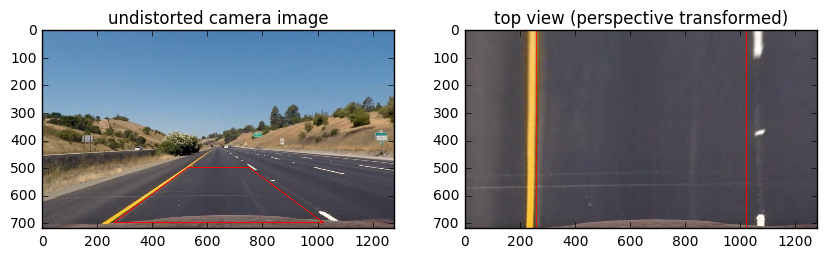

In [51]:
#=====================================================================
# Setup perspective transform

# generate perspective transform from src points defined as a trapeziod to
# dst defined as a rectangle
# xcenter - x-coord of vertical centerline through the road
# xoffsettop - x offset of left and right edges of the road at the top
# xoffsetbottom - x offset of left and right edges of the road at the bottom
# ytop - y-coord of the top of the road
# ybottom - y-coord of the bottom of the road
def setup_perspective(xcenter, xoffsettop, xoffsetbottom, ytop, ybottom):
    
    # These points were selected from test_images/straight_lines1.jpg after applying undistortion
    image = cv2.imread('./test_images/straight_lines1.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image, cam_mtx, dist_pars, None, cam_mtx)
    img_size = (image.shape[1], image.shape[0])

    # source points
    imsrc = np.float32(
        [[xcenter+xoffsetbottom,ybottom],
         [xcenter+xoffsettop,ytop],
         [xcenter-xoffsettop,ytop],
         [xcenter-xoffsetbottom,ybottom]])

    # destination points
    imdst = np.float32(
        [[xcenter+xoffsettop,0],
         [xcenter+xoffsettop,image.shape[0]],
         [xcenter-xoffsettop,image.shape[0]],
         [xcenter-xoffsettop,0]])

    # generate the perspective matrix
    pers_mtx = cv2.getPerspectiveTransform(imsrc, imdst)

    transformed = cv2.warpPerspective(undist, pers_mtx, img_size, flags=cv2.INTER_LINEAR)
    
    # draw src and dst guide lines on both images
    undist = cv2.polylines(undist, np.int32([imsrc]), True, (255,0,0), 2)
    transformed = cv2.polylines(transformed, np.int32([imdst]), True, (255,0,0), 2)
    
    # write images so I can inspect them manually
    cv2.imwrite('perspective_transformed.png', transformed)

    print('Points mapped from: ', imsrc)
    print('Points mapped to: ', imdst)
    print('Test perspective transform')
    f, axarr = plt.subplots(1,2,figsize=(10,10))
    axarr[0].imshow(undist)
    axarr[0].set_title('undistorted camera image')
    axarr[1].imshow(transformed)
    axarr[1].set_title('top view (perspective transformed)');
    return pers_mtx

#from IPython.html import widgets
#from IPython.html.widgets import interact
#from IPython.display import display

# set the transformation source points interactively
#pers_mtx = interact(setup_perspective, 
#                    xcenter=(639,641), 
#                    xoffsettop=(300,400),
#                    xoffsetbottom=(90,130), 
#                    ytop=(600,700), 
#                    ybottom=(450,550))

# Good starting point: xcenter=640, xoffsettop=316, xoffsetbottom=110, ytop=650, ybottom=500
pers_mtx= setup_perspective(xcenter=640, xoffsettop=380, xoffsetbottom=110, ytop=700, ybottom=500)
# Alt starting point: xcenter=640, xoffsettop=380, xoffsetbottom=40, ytop=700, ybottom=450
#pers_mtx= setup_perspective(xcenter=640, xoffsettop=380, xoffsetbottom=40, ytop=700, ybottom=450)

In [42]:
#=====================================================================
# utility functions

# read image as RGB
def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# undistort the image and apply perspective transform to generate top view
def generate_top_view(image, cam_mtx, dist_pars, pers_mtx):
    undist = cv2.undistort(image, cam_mtx, dist_pars, None, cam_mtx)
    img_size = (image.shape[1], image.shape[0])
    transformed = cv2.warpPerspective(undist, pers_mtx, img_size, flags=cv2.INTER_LINEAR)
    return transformed

# apply color and gradient threshold
def threshold(image, grad_thresh_min=20, grad_thresh_max=100, s_thresh_min = 170, s_thresh_max = 255):
    
    # For color threshold we need the s-channel from HLS space 
    # For gradient threshold we need grayscale image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # find x gradient
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= grad_thresh_min) & (scaled_sobel <= grad_thresh_max)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def fit_lines(thresholded_image):
    return line_params

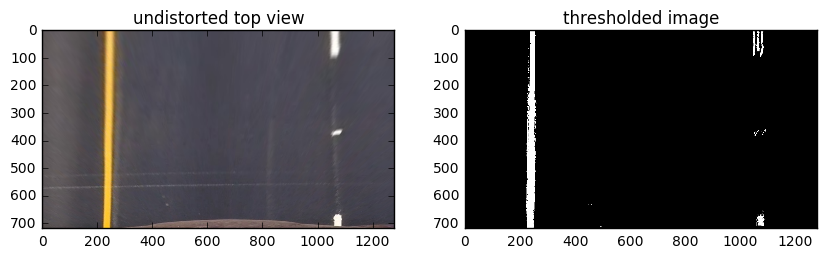

In [53]:
#=====================================================================
# processing pipeline

image = read_image('./test_images/straight_lines1.jpg')
top_view = generate_top_view(image, cam_mtx, dist_pars, pers_mtx)
thresholded = threshold(top_view, grad_thresh_min=50, grad_thresh_max=100, s_thresh_min = 170, s_thresh_max = 255)

f, axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(top_view)
axarr[0].set_title('undistorted top view')
axarr[1].imshow(thresholded,cmap='gray')
axarr[1].set_title('thresholded image');
